### Information processing primitives for the Joglekar & Wang rate model


The model ([Joglekar et. al., 2018](https://www.sciencedirect.com/science/article/pii/S0896627318301521)) is constructed using structural data from the monkey ([Markov et. al., 2013](https://academic.oup.com/cercor/article/24/1/17/272931)), and it is used to study mechanisms of propagation in the brain network via a mechanism called **global balance amplification (GBA)**, which consists of increasing long range excitatory to excitatory connections, and local recurrent inhibitions in order to maintain stability. Here, weak and strong GBA will be used as proxies for reduced and increased attention, respectively.

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/IPP_WANG")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.conn import conn_te
from tqdm import tqdm

from src.infodyn.conn_pid import conn_pid

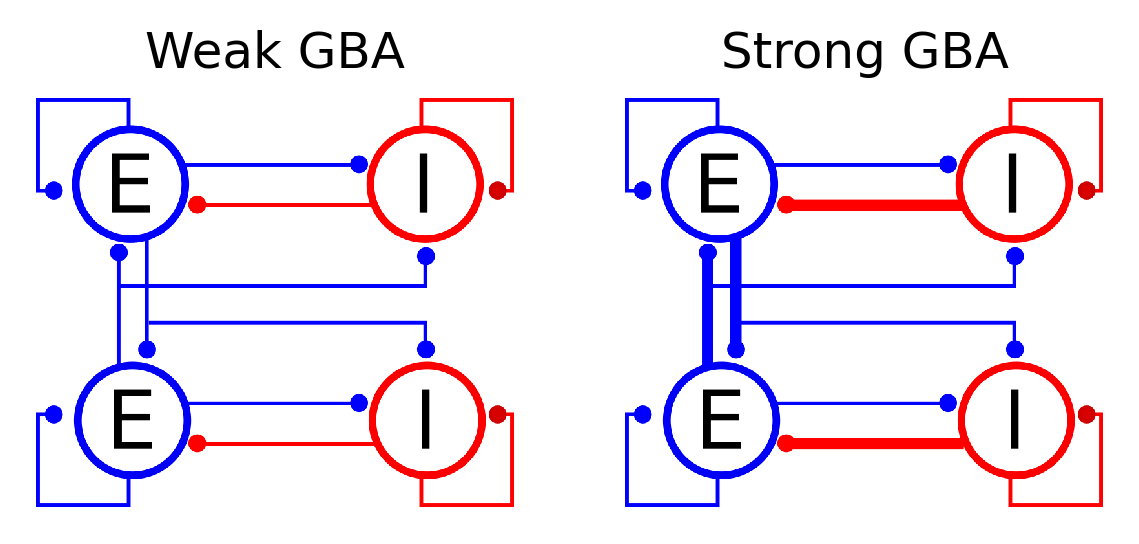

In [3]:
fig = plt.figure(figsize=(4, 2), dpi=300)


def plot_png(ax, figname):
    png = plt.imread(figname)
    plt.sca(ax)
    im = plt.imshow(png, interpolation='none')
    plt.axis('off')    
    pad = 10
    plt.xlim(-pad, png.shape[1]+pad)
    plt.ylim(png.shape[0]+pad, -pad)       
    
gs0 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.05,
    right=0.95,
    hspace=0.05,
    bottom=0.05,
    top=0.95,
)

axs0 = [plt.subplot(gs0[i]) for i in range(2)]

for i in range(2):
    plot_png(axs0[i], f"figures/circuit{i + 1}.png")
    if i == 0:
        plt.title("Weak GBA")
    else:
        plt.title("Strong GBA")

In [4]:
rates = xr.load_dataarray("../data/protocol0.nc")[..., ::10]

#### Firing rate average over trials

Here, we simulated two types of trials: fixation (F) and task (T). Those are used to emulate working memory tasks, were in task trials a stimulus is presented during a cue period, and a match period that are separated by a delay (or memory) period. In fixation trials, no stimulus is presented, therefore when computing information primitives, we use the presence or absence of stimulus as stimulus label (thus, there is no computation involve stimulus identity, only stimulus presence).


For the task trials, the stimulus is presented from 1000 to 1500 ms, and again from 3500 to 3800 ms. In total, 1000 task, and a 1000 fixation trials were simulated for each condition, strong and weak GBA. Hence, 4000 trials in total. The total simulation time was 7000 ms.

In [5]:
rois, times = rates.roi.data, rates.times.data
times = (times - 1000) / 1000

In [6]:
tticks = np.round(np.array([1., 1.5, 3.5, 3.8]) - 1., 2)
tidx = [np.abs(times - t).argmin() for t in tticks]

##### Fixation

In [7]:
rates_avg_f = rates.sel(trials=0).mean("trials")

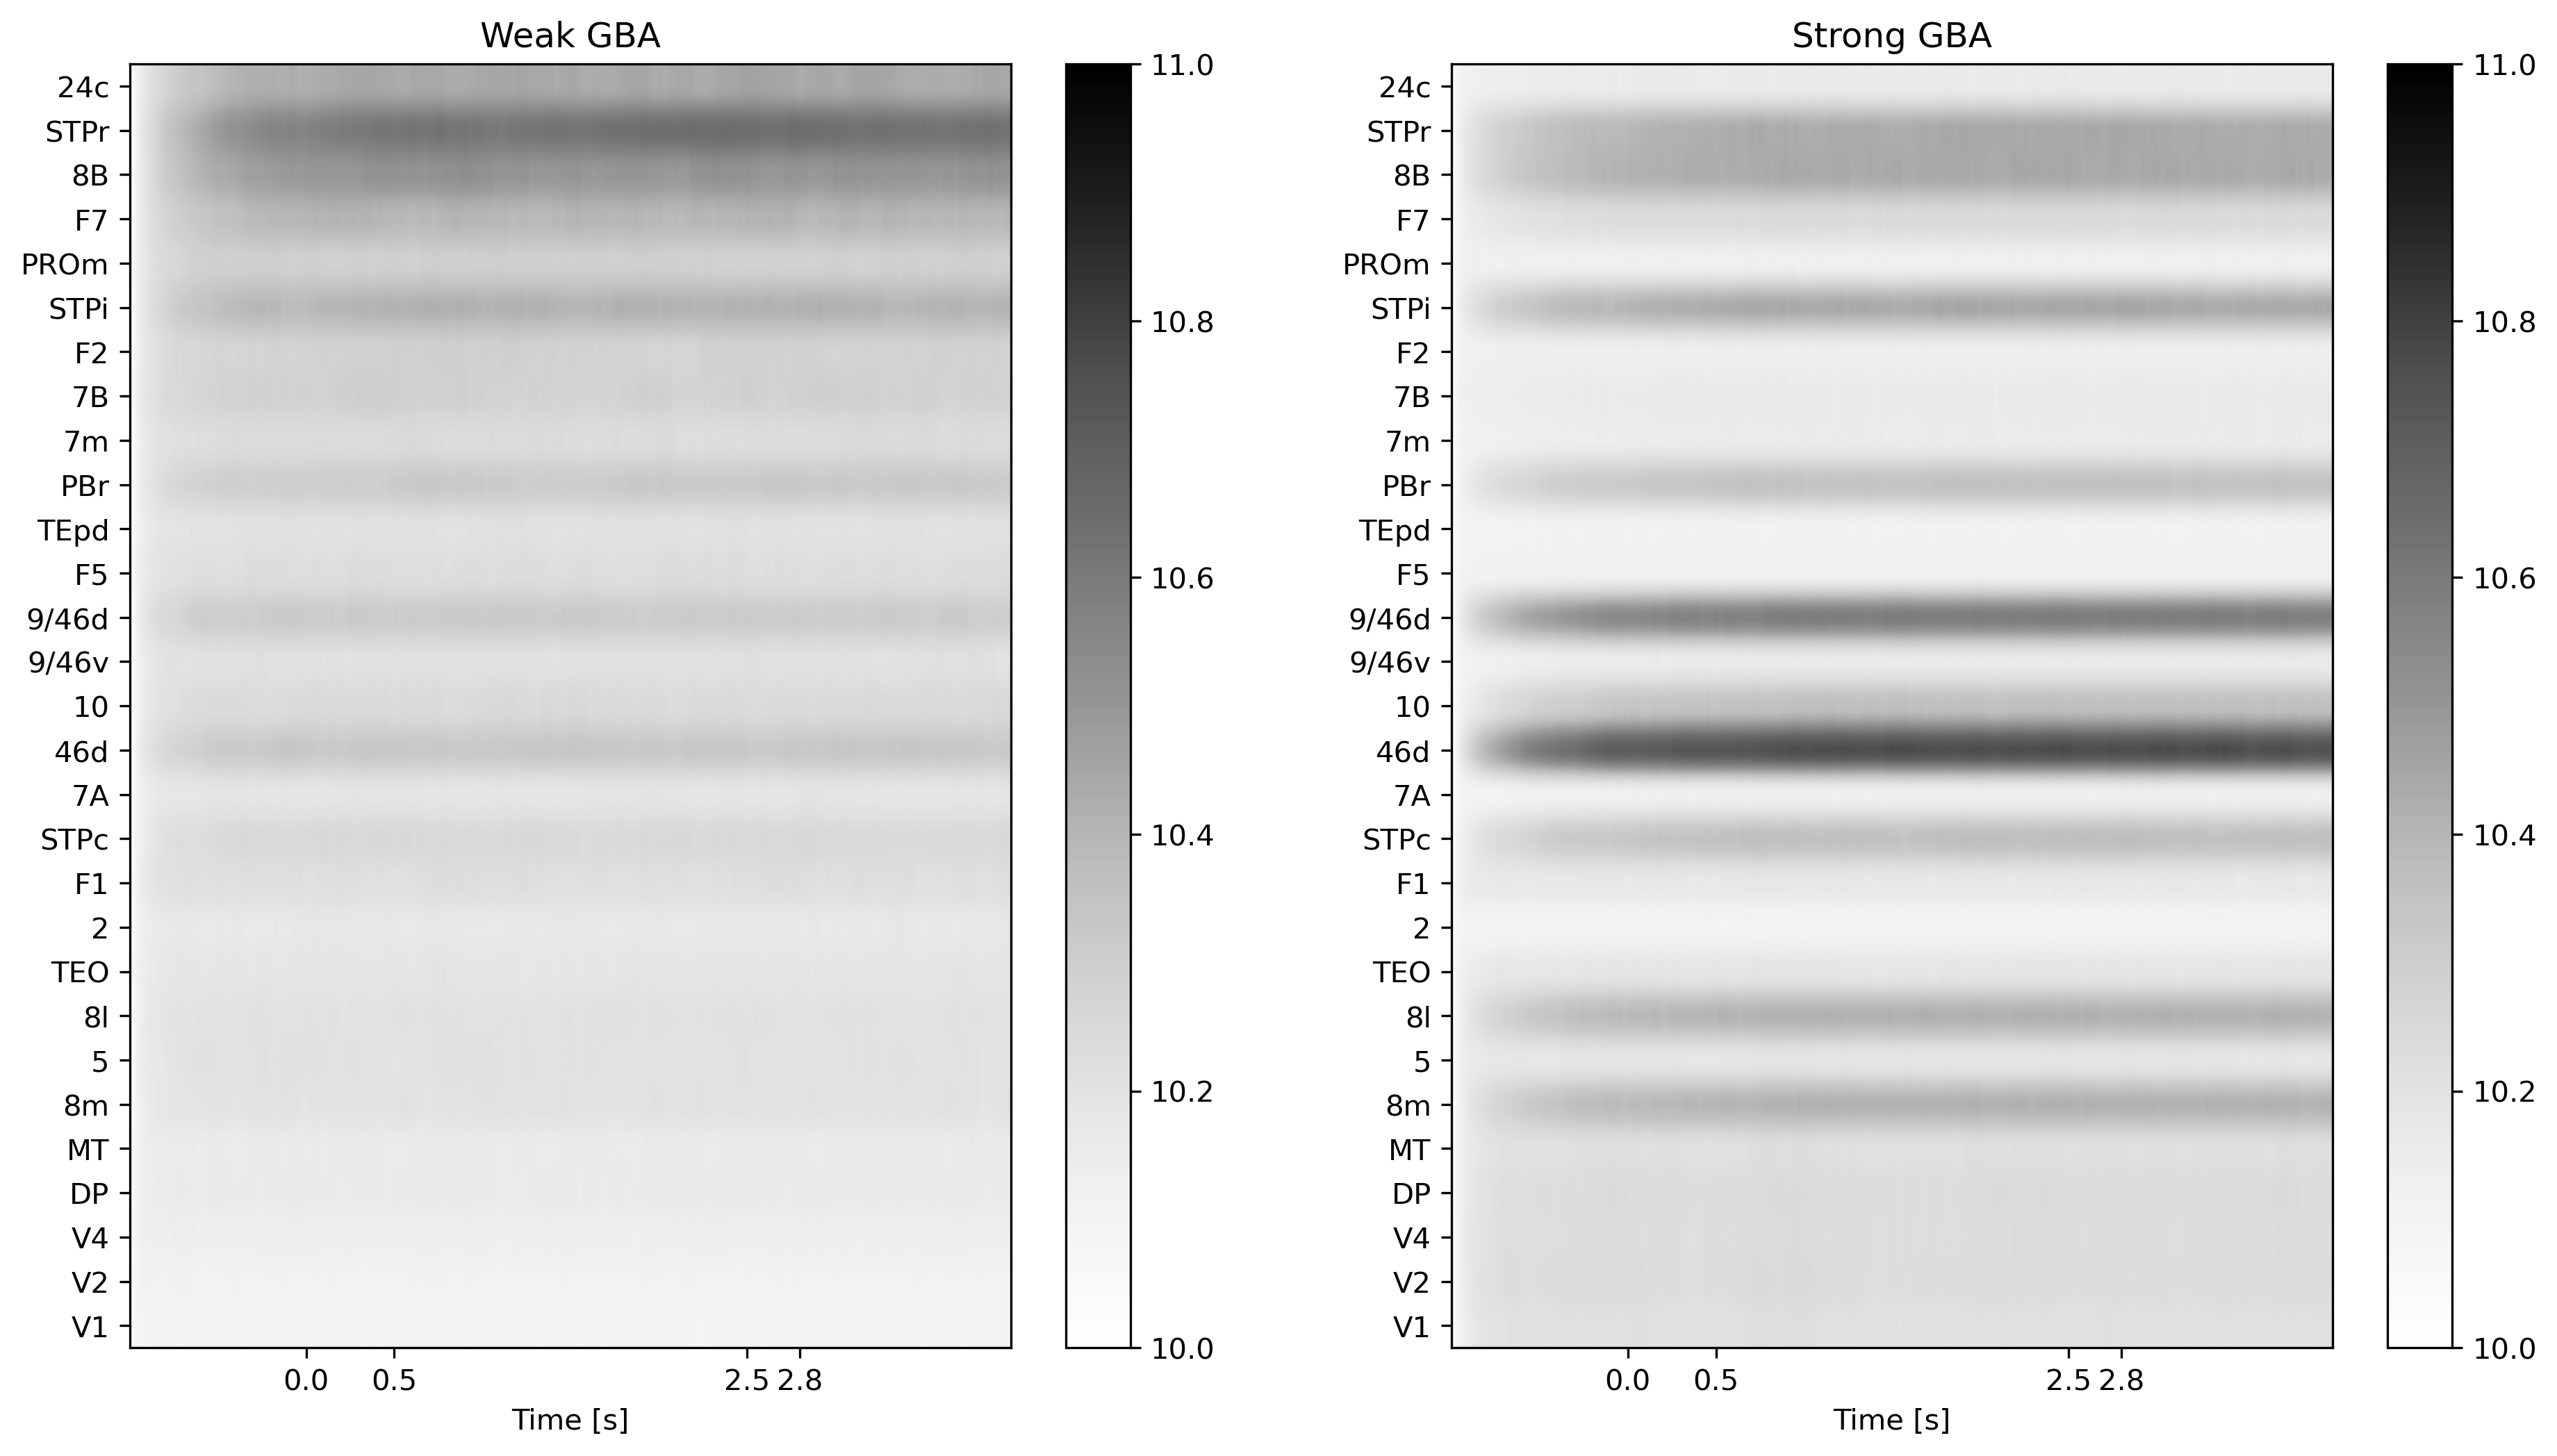

In [8]:
plt.figure(figsize=(15, 8), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(
    rates_avg_f.sel(gba="weak"), aspect="auto", origin="lower", cmap="Greys", vmax=11
)
plt.xticks(tidx, tticks)
plt.yticks(range(rates_avg_f.sizes["roi"]), rates_avg_f.roi.data)
plt.title("Weak GBA")
plt.xlabel("Time [s]")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(
    rates_avg_f.sel(gba="strong"), aspect="auto", origin="lower", cmap="Greys", vmax=11
)
plt.yticks(range(rates_avg_f.sizes["roi"]), rates_avg_f.roi.data)
plt.title("Strong GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()

Time-course (x-axis) of the avergae firing rate of each cortical area (y-axis) in the model, for **fixation** trials. 

##### Task

In [9]:
rates_avg_t = rates.sel(trials=1).mean("trials")

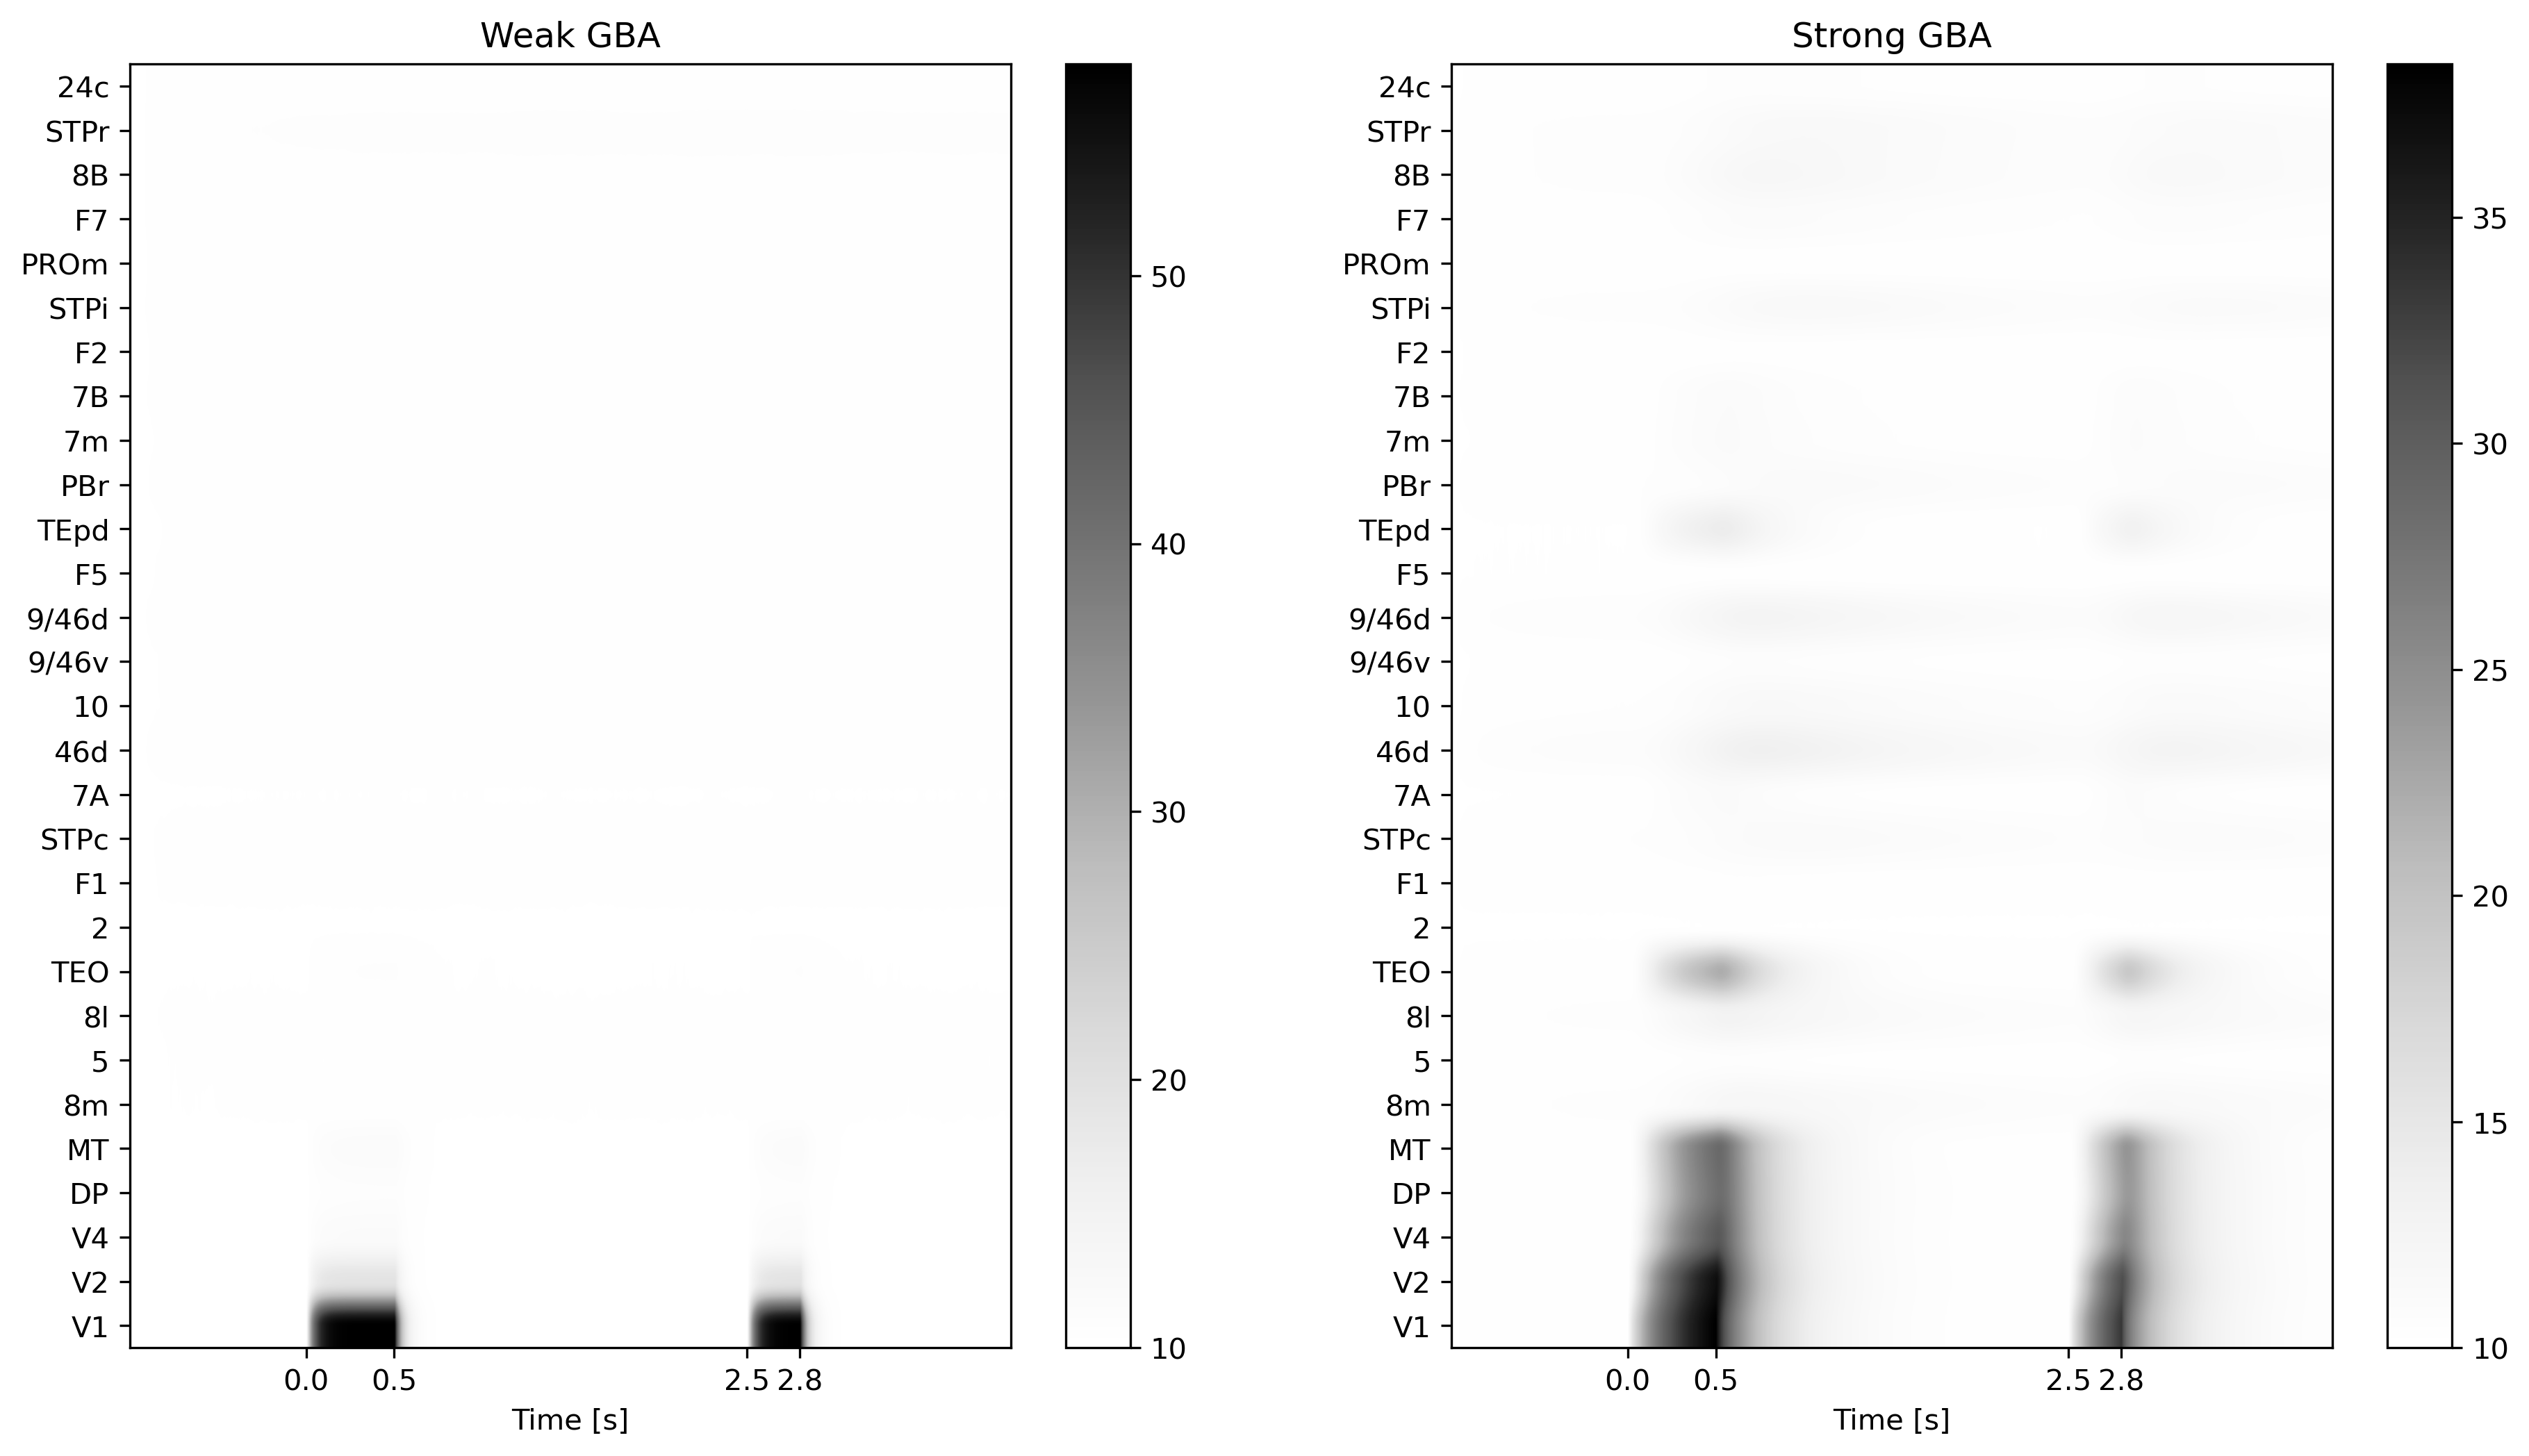

In [10]:
plt.figure(figsize=(15, 8), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(
    rates_avg_t.sel(gba="weak"), aspect="auto", origin="lower", cmap="Greys"
)
plt.yticks(range(rates_avg_t.sizes["roi"]), rates_avg_t.roi.data)
plt.title("Weak GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(
    rates_avg_t.sel(gba="strong"), aspect="auto", origin="lower", cmap="Greys"
)
plt.yticks(range(rates_avg_t.sizes["roi"]), rates_avg_t.roi.data)
plt.title("Strong GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()

Time-course (x-axis) of the avergae firing rate of each cortical area (y-axis) in the model, for **task** trials. 

#### Partial Information Decomposition

In [11]:
pairs = np.stack(([0] * 28, range(1, 29)), axis=1)

In [12]:
pid_weak = conn_pid(rates.sel(gba="weak"), "trials", "roi", "times", "cd", pairs=pairs)

Defining links (n_roi=29; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute PID on 28 connectivity pairs
    Apply the Gaussian Copula Rank Normalization
    Estimating PID in the network


  0%|          | Estimating MI on each node : 0/86 [00:00<?,       ?it/s]

In [13]:
pid_strong = conn_pid(rates.sel(gba="strong"), "trials", "roi", "times", "cd", pairs=pairs)

Defining links (n_roi=29; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute PID on 28 connectivity pairs
    Apply the Gaussian Copula Rank Normalization
    Estimating PID in the network


  0%|          | Estimating MI on each node : 0/86 [00:00<?,       ?it/s]

#### Mutual Information MI(RATE, STIMULUS PRESENCE)

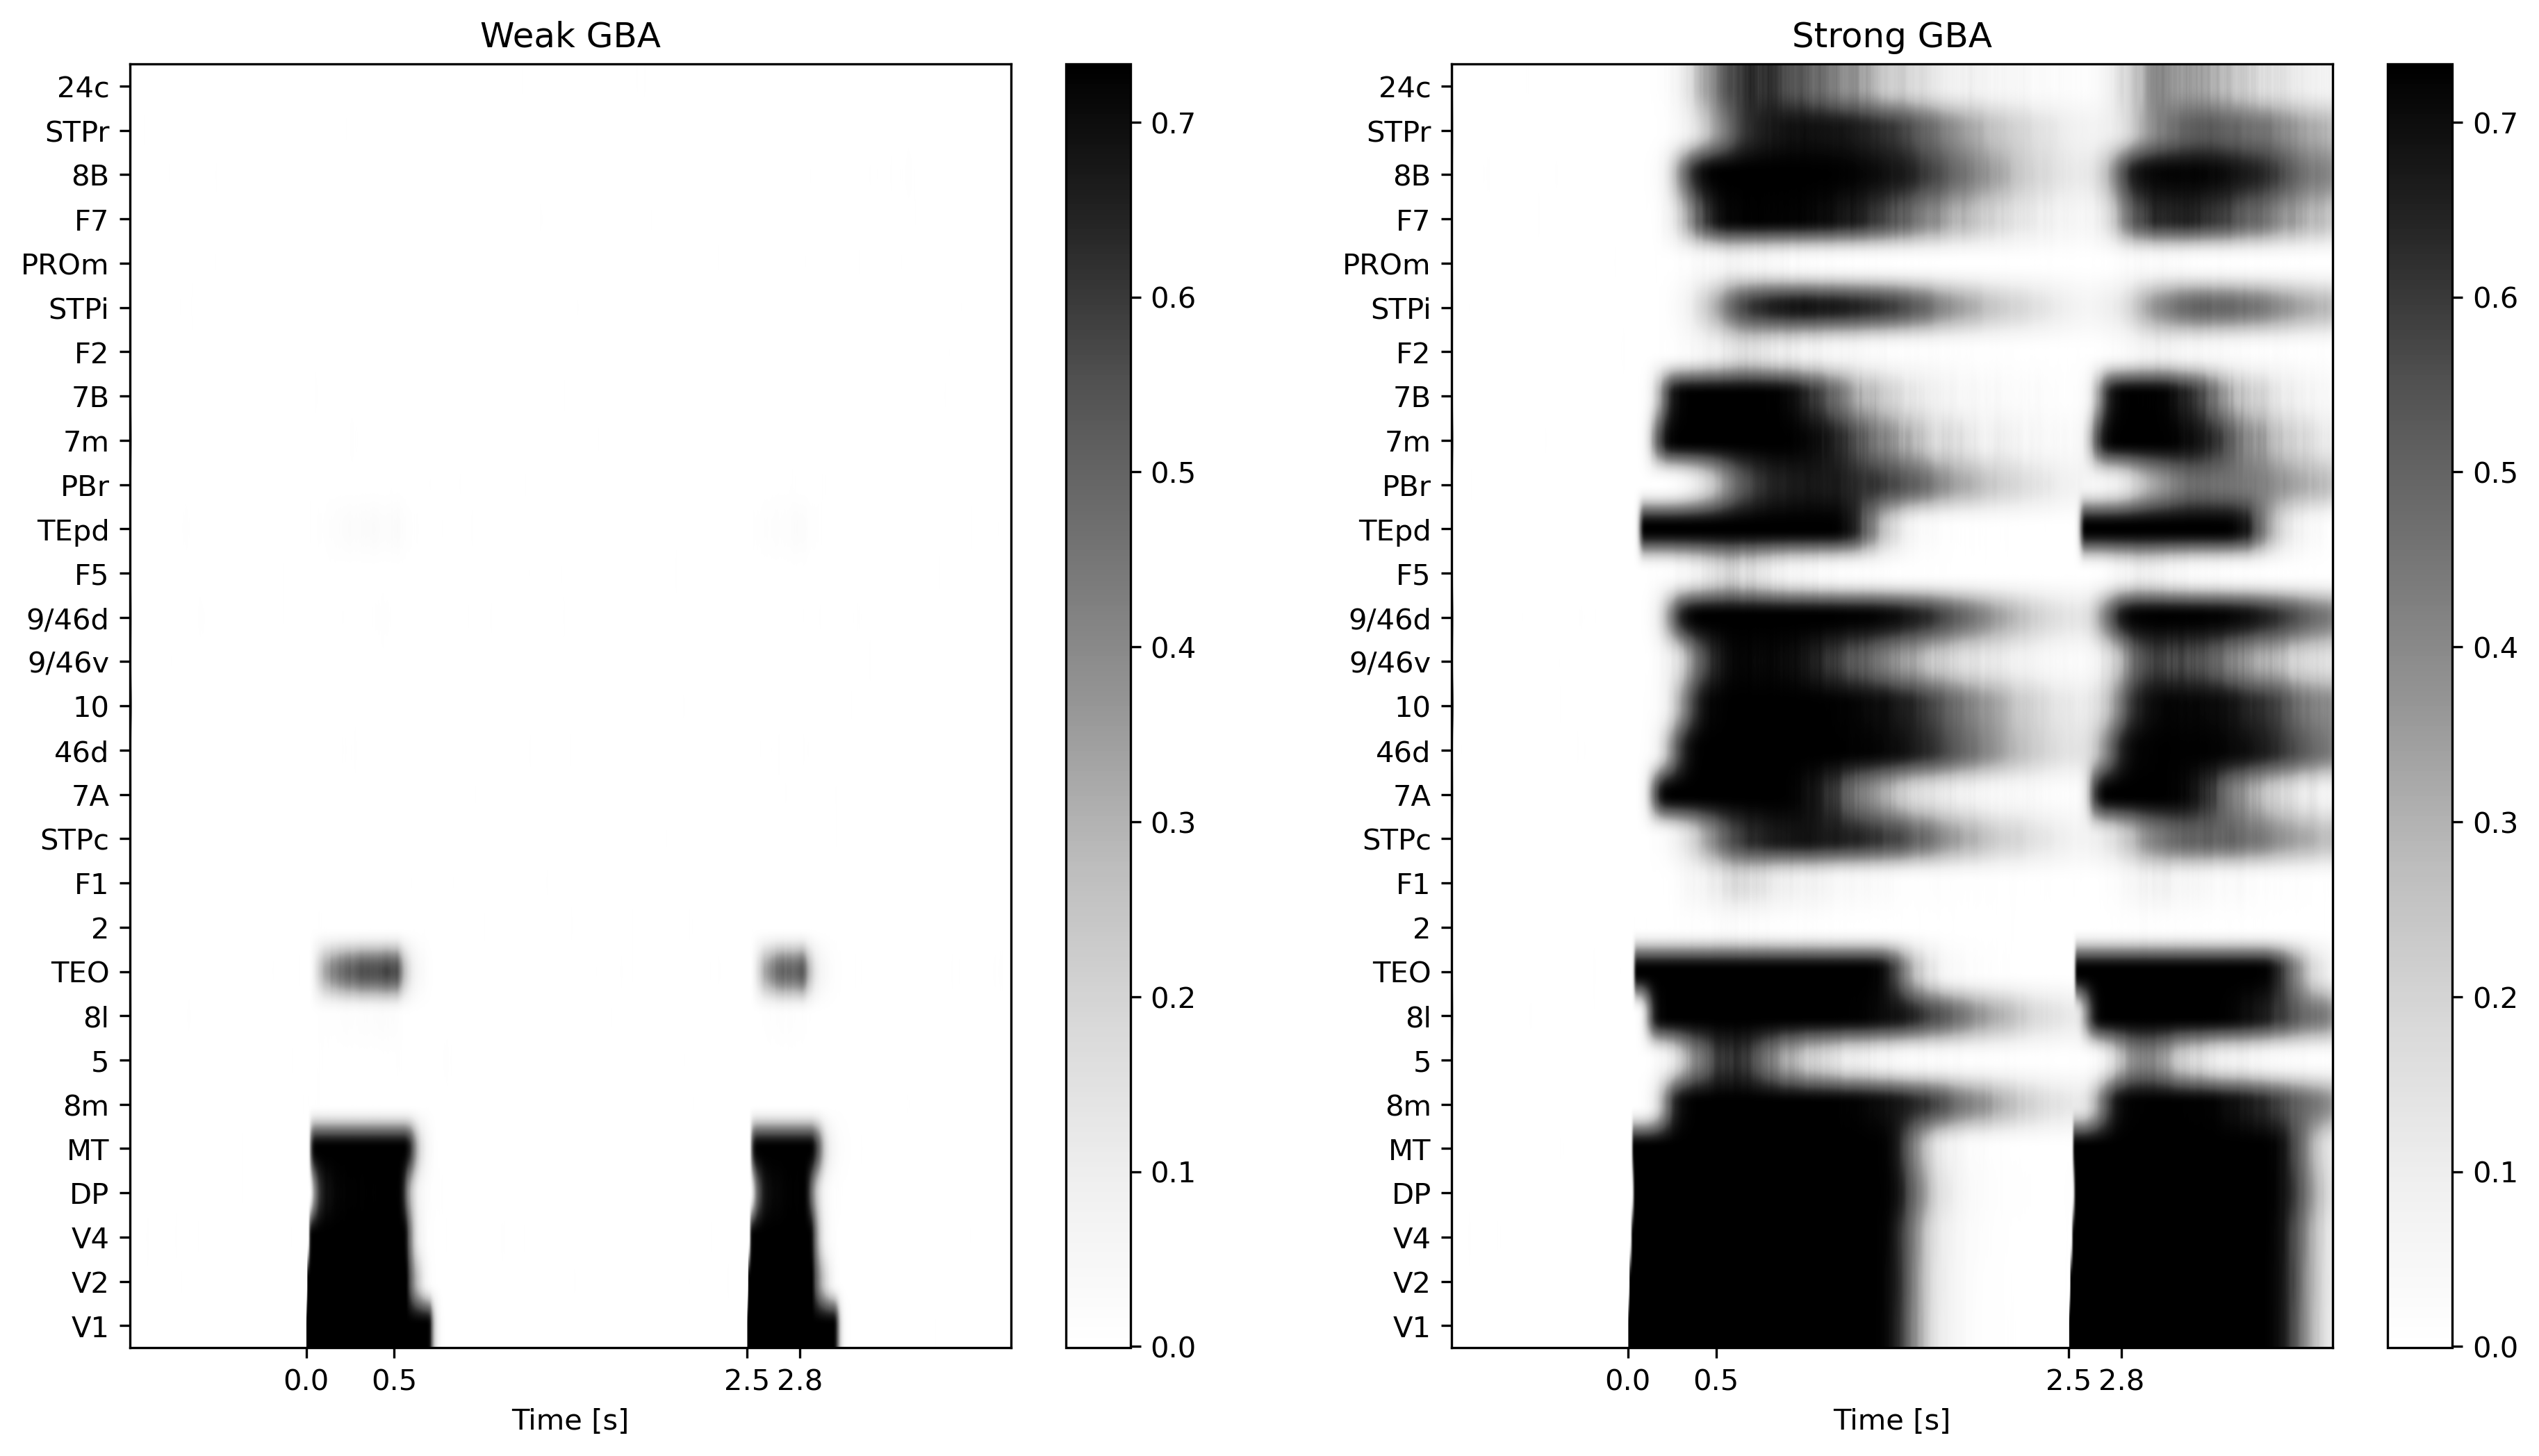

In [14]:
plt.figure(figsize=(15, 8), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(pid_weak[0], aspect="auto", cmap="Greys", origin="lower")
plt.yticks(range(rates_avg_t.sizes["roi"]), rates_avg_t.roi.data)
plt.title("Weak GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(pid_strong[0], aspect="auto", cmap="Greys", origin="lower")
plt.yticks(range(rates_avg_t.sizes["roi"]), rates_avg_t.roi.data)
plt.title("Strong GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()

Mutual information between firing rate and stimulus presence (fixation vs. task trials), for each cortical area (y-axis) and time (x-axis).

#### Total information, sinergy

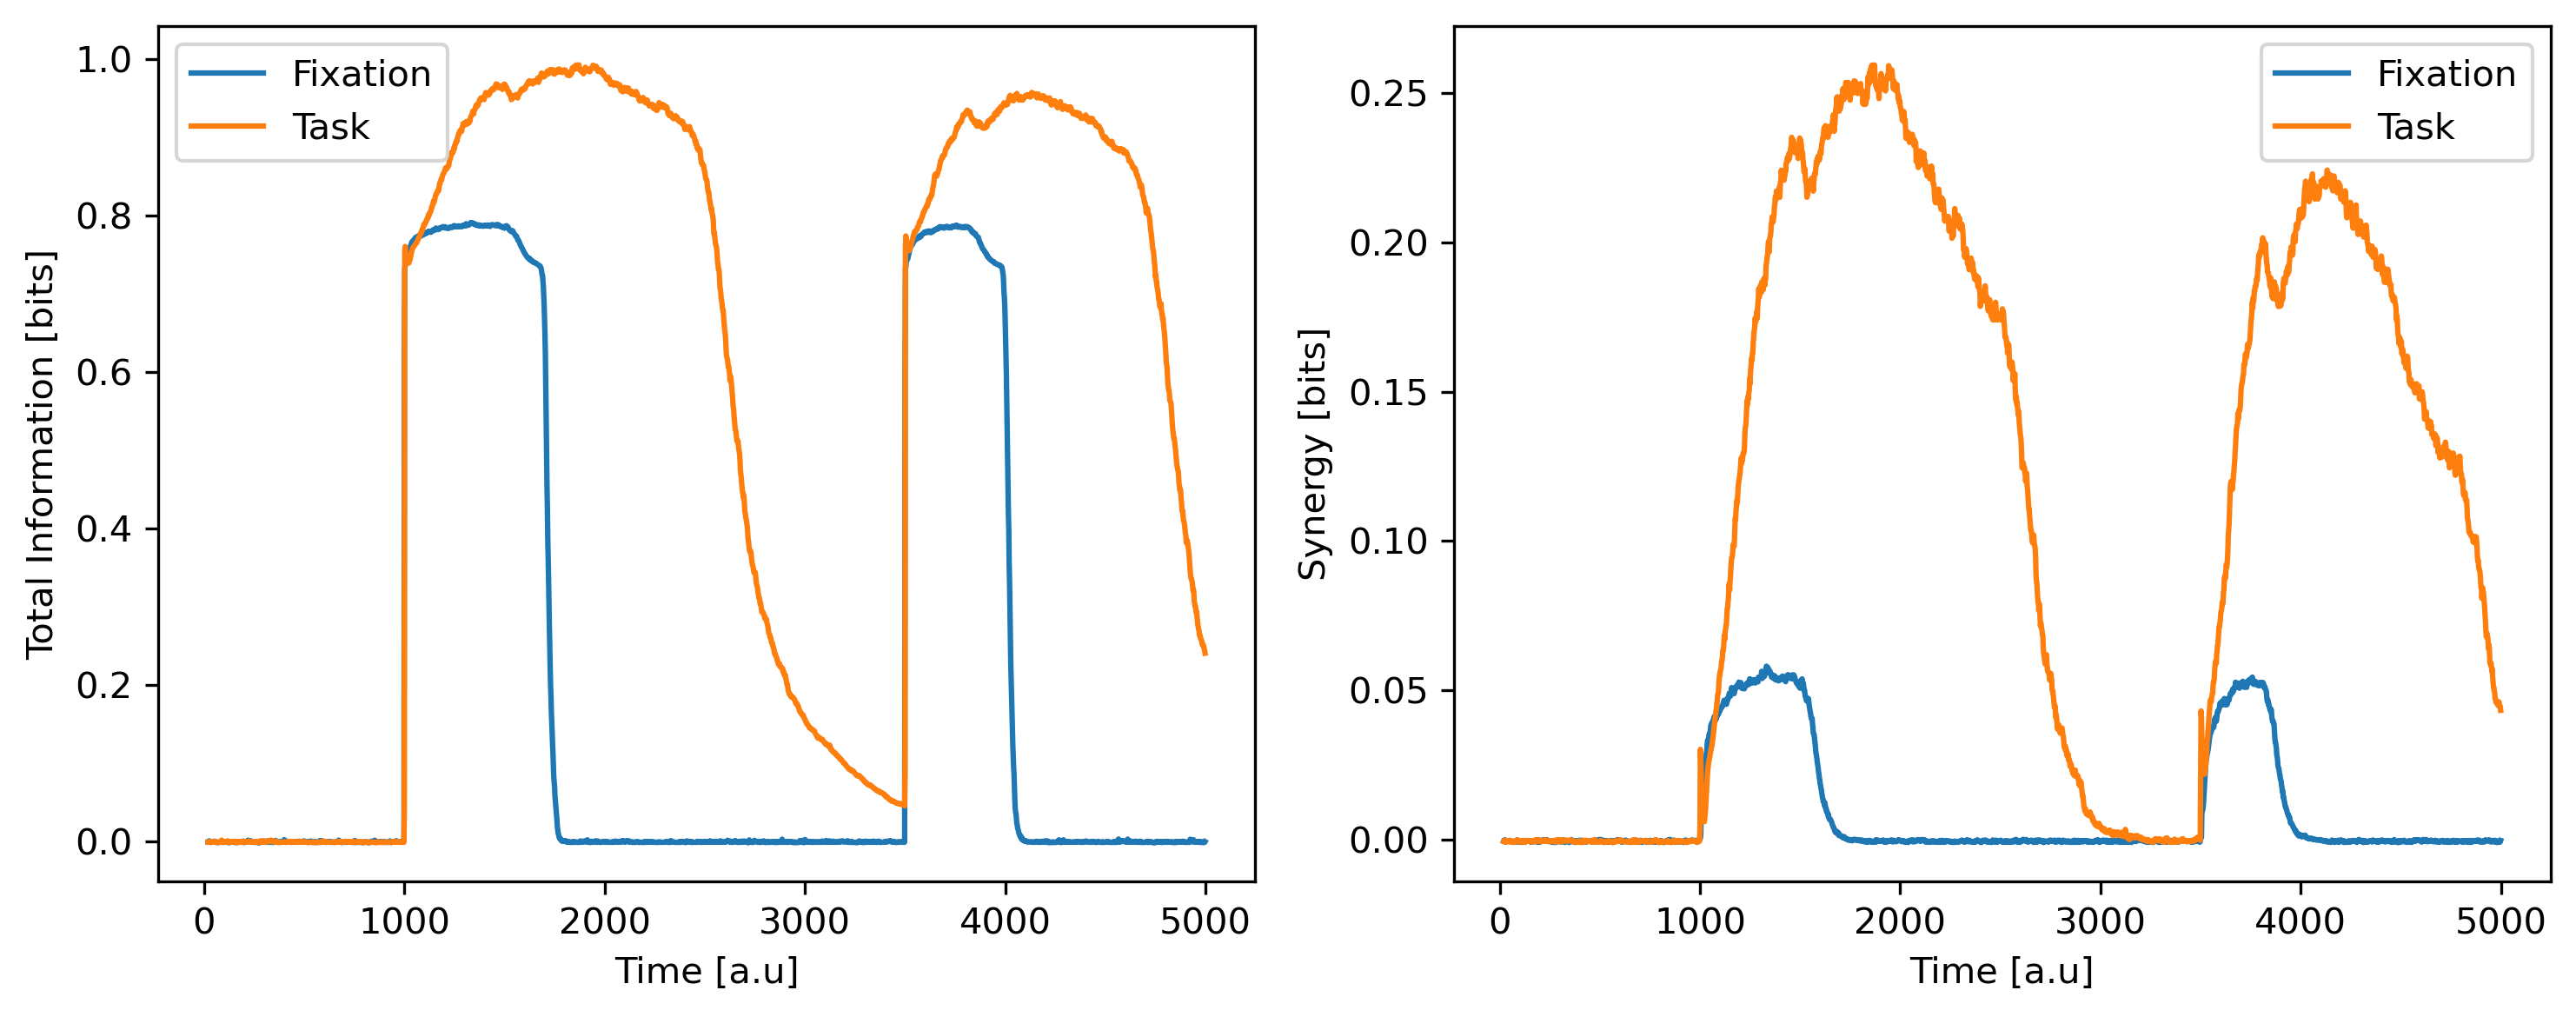

In [17]:
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(121)
pid_weak[2][..., 10:].mean("roi").plot()
pid_strong[2][..., 10:].mean("roi").plot()
plt.legend(["Fixation", "Task"])
plt.xlabel("Time [a.u]")
plt.ylabel("Total Information [bits]")


plt.subplot(122)
pid_weak[4][..., 10:].mean("roi").plot()
pid_strong[4][..., 10:].mean("roi").plot()
plt.legend(["Fixation", "Task"])
plt.xlabel("Time [a.u]")
plt.ylabel("Synergy [bits]")

plt.tight_layout()

Time-course of the total information (left) and synergy (right). The total information and synergy is measured between the firing rate of V1 and all other cortical areas (pairwise), and stimulus presence. In the plots above we show the total information and synergy averaged over pairs or areas that involves V1. 

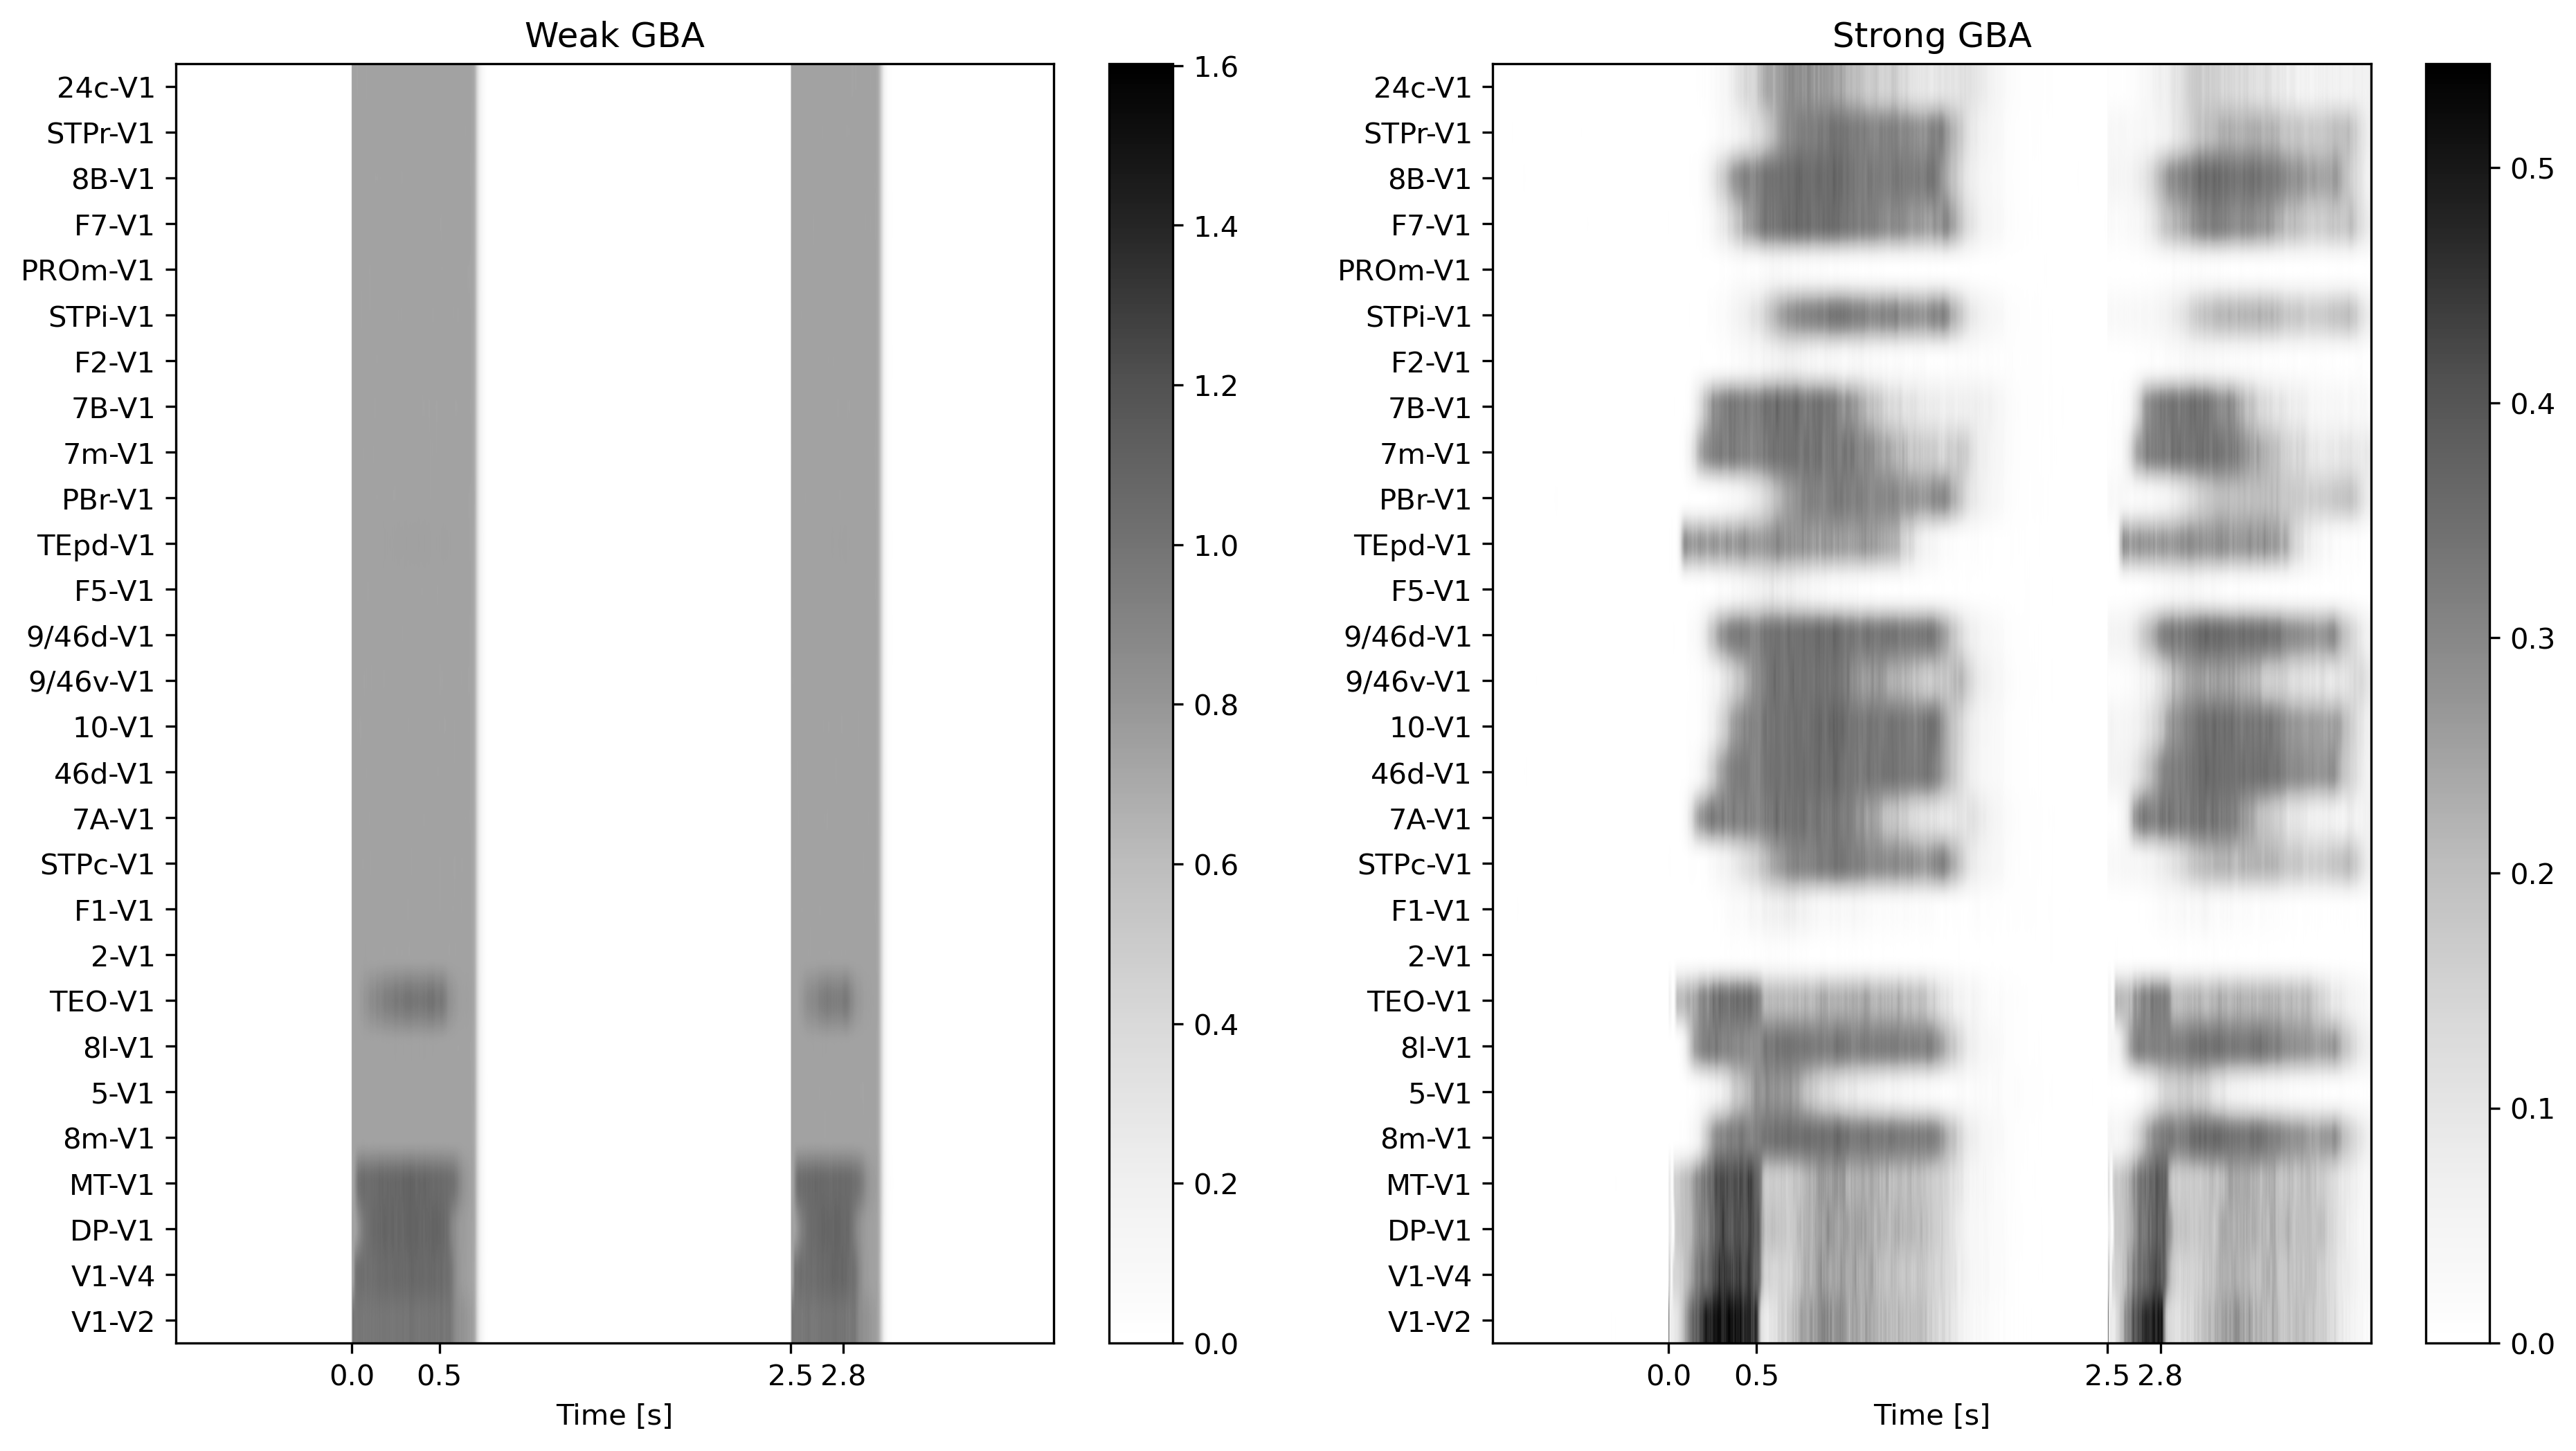

In [26]:
plt.figure(figsize=(15, 8), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(pid_weak[2], aspect="auto", cmap="Greys", origin="lower", vmin=0)
plt.yticks(range(pid_weak[2].sizes["roi"]), pid_weak[2].roi.data)
plt.title("Weak GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(pid_strong[4], aspect="auto", cmap="Greys", origin="lower", vmin=0)
plt.yticks(range(pid_weak[2].sizes["roi"]), pid_weak[2].roi.data)
plt.title("Strong GBA")
plt.xticks(tidx, tticks)
plt.xlabel("Time [s]")
plt.colorbar()

Same as the plot above, however without thaking the average over areas (y-axis).

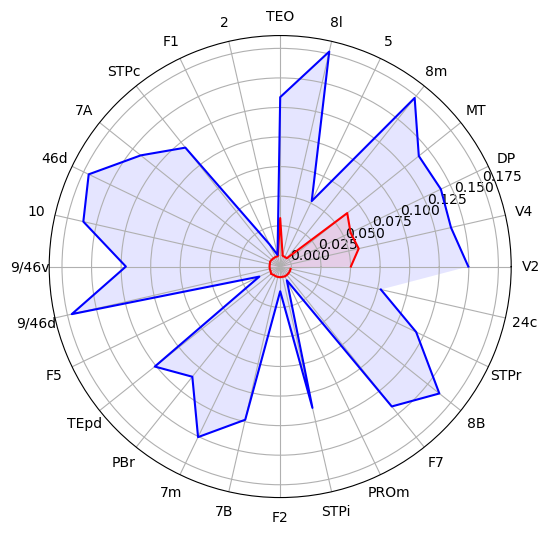

In [33]:
syn_w = pid_weak[-1].mean("times")
syn_s = pid_strong[-1].mean("times")

# Compute pie slices
N = 28
theta = np.linspace(0, 2 * np.pi, N, endpoint=False) 
width = .25

plt.figure(figsize=(10, 6))
plt.subplot(polar=True)

lines, labels = plt.thetagrids(theta * 360 / (2*np.pi),
                                                         (rois[1:]))


# Plot actual sales graph
plt.plot(theta, syn_w, 'r')
plt.fill(theta, syn_w, 'r', alpha = 0.1)
plt.plot(theta, syn_s, 'b')
plt.fill(theta, syn_s, 'b', alpha = 0.1)

Total synergy (in this case averge over time), distribution for each cortical area for weak (red) and strong (blue) GBA.

#### Active information storage

In [27]:
from frites.core import gcmi_nd_cc

In [28]:
rois = rates.roi.data

In [29]:
AISw = []

for roi in tqdm(rois):
    AISw += [
        gcmi_nd_cc(
            rates.sel(gba="weak", roi=roi)[..., :-40].data,
            rates.sel(gba="weak", roi=roi)[..., 40:].data,
            traxis=0,
            mvaxis=None,
        )
    ]

AISw = xr.DataArray(AISw, dims=("roi", "times"), coords=(rois, rates.times[:-40]))

100%|███████████████████████████████████████████████████████████| 29/29 [00:47<00:00,  1.65s/it]


In [30]:
AISs = []

for roi in tqdm(rois):
    AISs += [
        gcmi_nd_cc(
            rates.sel(gba="strong", roi=roi)[..., :-40].data,
            rates.sel(gba="strong", roi=roi)[..., 40:].data,
            traxis=0,
            mvaxis=None,
        )
    ]

AISs = xr.DataArray(AISs, dims=("roi", "times"), coords=(rois, rates.times[:-40]))

100%|███████████████████████████████████████████████████████████| 29/29 [00:48<00:00,  1.69s/it]


In [31]:
AIS = xr.concat([AISw, AISs], "gba")

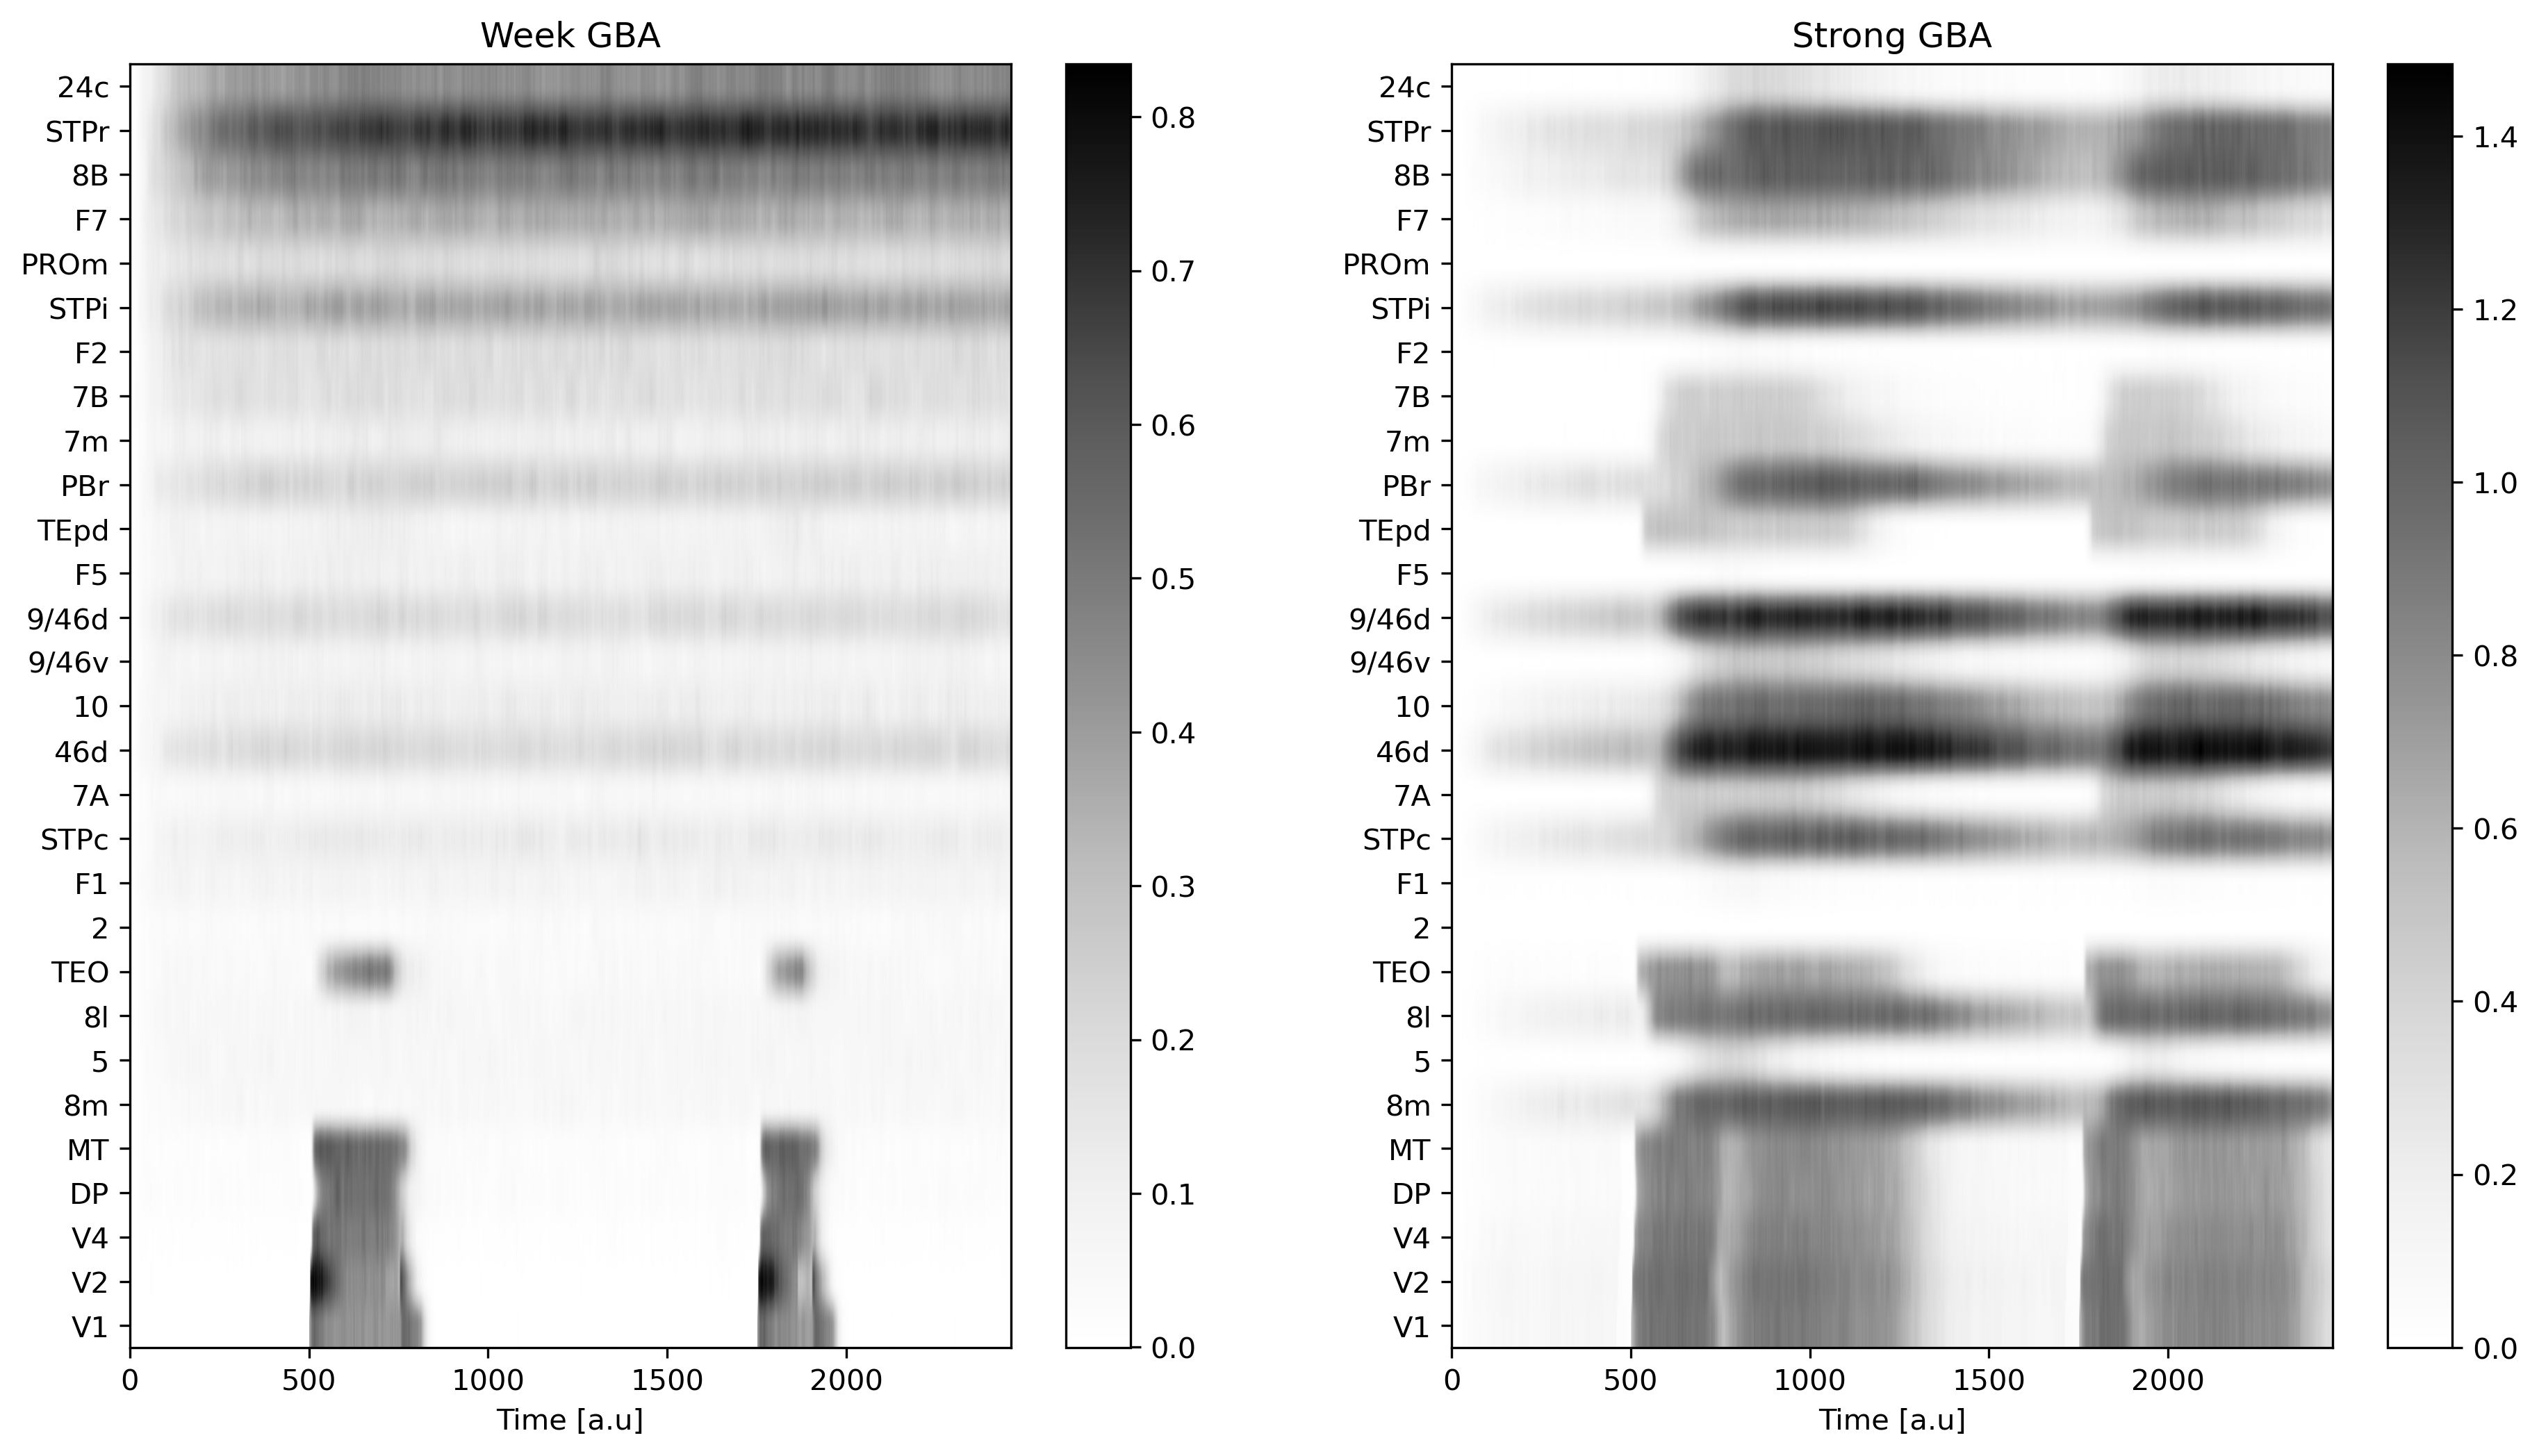

In [32]:
plt.figure(figsize=(15, 8), dpi=300)

plt.subplot(121)
plt.imshow(AIS.isel(gba=0), aspect="auto", cmap="Greys", origin="lower")
plt.title("Week GBA")
plt.xlabel("Time [a.u]")
plt.colorbar()
plt.yticks(range(len(rois)), rois)
plt.subplot(122)
plt.imshow(AIS.isel(gba=1), aspect="auto", cmap="Greys", origin="lower")
plt.title("Strong GBA")
plt.yticks(range(len(rois)), rois)
plt.xlabel("Time [a.u]")
plt.colorbar()

Active information storage time-course (x-axis) for each cortical area (y-axis) in the model. For the weak (left) and strong GBA (right) states.

In [34]:
ais = AIS.mean("times")

(0.0, 1.1)

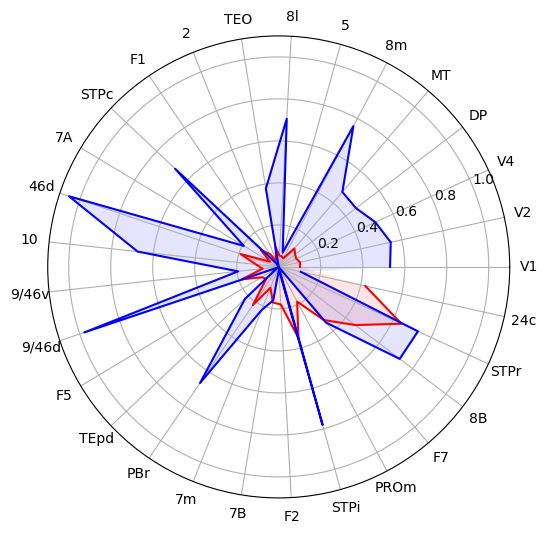

In [36]:
# Compute pie slices
N = 29
theta = np.linspace(0, 2 * np.pi, N, endpoint=False) 
width = .25

plt.figure(figsize=(10, 6))
plt.subplot(polar=True)

lines, labels = plt.thetagrids(theta * 360 / (2*np.pi),
                                                         (rois))


# Plot actual sales graph
plt.plot(theta, ais.sel(gba=0), 'r')
plt.fill(theta, ais.sel(gba=0), 'r', alpha = 0.1)
plt.plot(theta, ais.sel(gba=1), 'b')
plt.fill(theta, ais.sel(gba=1), 'b', alpha = 0.1)
plt.ylim(0, 1.1)

Total active information storage (in this case averge over time), distribution for each cortical area for weak (red) and strong (blue) GBA.